# 파충강(거북목, 뱀목, 악어목) COI 염기서열 추출 후 군집화(Alignment 과정 x + 비지도학습)

## 데이터 수집 자동 크롤러를 위한 함수들(getOrganism() -> getGenbank())

In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 10000, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    #[220811_1431]NOTED getOrganism() -> getGenbank()
    return r

In [3]:
species = ['Gekko gecko']

count = 0

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    Idlist = [id for id in Idlist if getGenbank(id).organism in s and 'COI' in getGenbank(id).definition]
    for id in Idlist:
        getFasta(id)
        count += 1
print(count)

## creating MZ069142.1.fasta...
## creating MZ069139.1.fasta...
## creating MZ069130.1.fasta...
## creating MZ069129.1.fasta...
## creating MZ069128.1.fasta...
## creating MZ069127.1.fasta...
## creating MZ069126.1.fasta...
## creating MZ069124.1.fasta...
## creating MZ069123.1.fasta...
## creating MZ069122.1.fasta...
## creating MZ069121.1.fasta...
## creating MZ069118.1.fasta...
## creating MZ069117.1.fasta...
## creating MZ069116.1.fasta...
## creating MN062180.1.fasta...
## creating MG257637.1.fasta...
## creating MG257636.1.fasta...
## creating MG257635.1.fasta...
## creating MG257634.1.fasta...
## creating MG257633.1.fasta...
## creating MG257632.1.fasta...
## creating MG257631.1.fasta...
## creating MG257630.1.fasta...
## creating MG257629.1.fasta...
## creating MG257628.1.fasta...
## creating MG257627.1.fasta...
## creating MG257626.1.fasta...
## creating MG257625.1.fasta...
## creating MG257624.1.fasta...
## creating MG257623.1.fasta...
## creating MG257622.1.fasta...
## creat

## alignment 대신 GC함량 값으로 시퀀스 슬라이싱

### GC함량 최댓값 범위 확인

In [2]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all.fasta', 'fasta')

l = []
for record in file:
    l.append(len(record.seq))
k_gc = min(l)
print(k_gc)
#[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

gc_df = pd.DataFrame(columns = ['id', 'start index', 'gc-contents'])
file = SeqIO.parse('all.fasta', 'fasta')

for i, record in enumerate(file):
    index = 0
    gc_rates = []
    while(index + k_gc <= len(record.seq)):
        mer = record.seq[index:index + k_gc]
        gc_rates.append(GC(mer))
        index += 1
        
    gc_df.loc[i, 'id'] = record.id
    gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
    gc_df.loc[i, 'gc-contents'] = max(gc_rates)
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장
gc_df.set_index('id', inplace = True, drop = True)

562


In [3]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

gc_df

,start index,gc-contents
id,,
AF114249.1,1166,48.220641
HM362936.1,0,47.686833
HM362937.1,0,48.042705
HM362938.1,0,48.042705
HM362939.1,0,47.686833
HM362940.1,0,47.864769
HM362941.1,0,47.686833
HM362942.1,0,47.864769
HM362943.1,0,47.686833


### 기존 데이터 슬라이싱 후 3-mer 적용

In [19]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all.fasta', 'fasta')

k = 3
dict = {}
df = pd.DataFrame()

#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['GC-contents'] = 0
    datatype['target'] = 0
    
init(df)

for i, record in enumerate(file):
    init(dict)
    record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
    #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
    dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
    #[220805_1025]CREATED 최대 GC 값 저장
    dict['target'] = getGenbank(record.id).organism
    
    index = 0
    
    if(len(record.seq) >= k):
        while(index + k <= len(record.seq)):
            mer = record.seq[index:index + k]
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
            dict[mer] += 1
            index += 1
    df.loc[i] = dict

KeyError: 0

In [9]:
#[220811_1437]NOTED 9종으로 잘 크롤링되었음을 확인
df['target'].unique()

array(['Gekko gecko'], dtype=object)

In [5]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,ACC,ACT,ATA,ATG,ATC,ATT,GAA,GAG,GAC,GAT,GGA,GGG,GGC,GGT,GCA,GCG,GCC,GCT,GTA,GTG,GTC,GTT,CAA,CAG,CAC,CAT,CGA,CGG,CGC,CGT,CCA,CCG,CCC,CCT,CTA,CTG,CTC,CTT,TAA,TAG,TAC,TAT,TGA,TGG,TGC,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,17,5,18,12,5,7,10,8,18,3,22,14,3,4,7,9,2,8,7,3,4,9,9,2,8,2,11,8,7,3,4,5,17,8,19,7,6,5,4,4,14,8,17,18,17,9,13,11,16,9,13,1,5,3,5,5,11,6,8,10,12,2,11,12,48.220641,Gekko gecko
1,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,47.686833,Gekko gecko
2,4,4,11,15,1,5,13,6,13,4,16,12,14,5,12,11,5,4,9,4,8,12,8,2,14,5,8,8,8,4,3,4,8,7,15,14,5,7,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,7,9,8,5,3,10,12,11,8,9,11,48.042705,Gekko gecko
3,4,4,11,15,1,5,13,6,13,4,16,12,14,5,12,11,5,4,9,4,8,12,8,2,14,5,8,8,8,4,3,4,8,7,15,14,5,7,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,7,9,8,5,3,10,12,11,8,9,11,48.042705,Gekko gecko
4,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,47.686833,Gekko gecko
5,4,4,11,15,1,5,13,5,13,4,16,12,14,5,11,13,5,3,9,5,8,13,8,2,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,47.864769,Gekko gecko
6,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,47.686833,Gekko gecko
7,4,4,11,15,1,5,13,6,13,4,16,12,14,4,11,13,5,4,9,4,8,12,8,2,14,5,8,8,8,5,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,47.864769,Gekko gecko
8,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,47.686833,Gekko gecko
9,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,47.686833,Gekko gecko


In [11]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,ACC,ACT,ATA,ATG,ATC,ATT,GAA,GAG,GAC,GAT,GGA,GGG,GGC,GGT,GCA,GCG,GCC,GCT,GTA,GTG,GTC,GTT,CAA,CAG,CAC,CAT,CGA,CGG,CGC,CGT,CCA,CCG,CCC,CCT,CTA,CTG,CTC,CTT,TAA,TAG,TAC,TAT,TGA,TGG,TGC,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,17,5,18,12,5,7,10,8,18,3,22,14,3,4,7,9,2,8,7,3,4,9,9,2,8,2,11,8,7,3,4,5,17,8,19,7,6,5,4,4,14,8,17,18,17,9,13,11,16,9,13,1,5,3,5,5,11,6,8,10,12,2,11,12,48.220641,0
1,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,47.686833,0
2,4,4,11,15,1,5,13,6,13,4,16,12,14,5,12,11,5,4,9,4,8,12,8,2,14,5,8,8,8,4,3,4,8,7,15,14,5,7,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,7,9,8,5,3,10,12,11,8,9,11,48.042705,0
3,4,4,11,15,1,5,13,6,13,4,16,12,14,5,12,11,5,4,9,4,8,12,8,2,14,5,8,8,8,4,3,4,8,7,15,14,5,7,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,7,9,8,5,3,10,12,11,8,9,11,48.042705,0
4,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,47.686833,0


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#[220805_1714]NOTED* GC함량을 정규화
scaler.fit(df['GC-contents'].array.reshape(-1, 1))
gc_scaled = scaler.transform(df['GC-contents'].array.reshape(-1, 1))
df['GC-contents'] = gc_scaled

In [13]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,ACC,ACT,ATA,ATG,ATC,ATT,GAA,GAG,GAC,GAT,GGA,GGG,GGC,GGT,GCA,GCG,GCC,GCT,GTA,GTG,GTC,GTT,CAA,CAG,CAC,CAT,CGA,CGG,CGC,CGT,CCA,CCG,CCC,CCT,CTA,CTG,CTC,CTT,TAA,TAG,TAC,TAT,TGA,TGG,TGC,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,17,5,18,12,5,7,10,8,18,3,22,14,3,4,7,9,2,8,7,3,4,9,9,2,8,2,11,8,7,3,4,5,17,8,19,7,6,5,4,4,14,8,17,18,17,9,13,11,16,9,13,1,5,3,5,5,11,6,8,10,12,2,11,12,0.478261,0
1,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,0.347826,0
2,4,4,11,15,1,5,13,6,13,4,16,12,14,5,12,11,5,4,9,4,8,12,8,2,14,5,8,8,8,4,3,4,8,7,15,14,5,7,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,7,9,8,5,3,10,12,11,8,9,11,0.434783,0
3,4,4,11,15,1,5,13,6,13,4,16,12,14,5,12,11,5,4,9,4,8,12,8,2,14,5,8,8,8,4,3,4,8,7,15,14,5,7,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,7,9,8,5,3,10,12,11,8,9,11,0.434783,0
4,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,0.347826,0
5,4,4,11,15,1,5,13,5,13,4,16,12,14,5,11,13,5,3,9,5,8,13,8,2,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,0.391304,0
6,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,0.347826,0
7,4,4,11,15,1,5,13,6,13,4,16,12,14,4,11,13,5,4,9,4,8,12,8,2,14,5,8,8,8,5,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,0.391304,0
8,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,0.347826,0
9,4,4,11,15,1,5,13,6,13,4,16,12,14,5,11,13,5,4,9,5,9,11,8,1,14,5,8,8,8,4,3,3,8,7,15,14,5,6,5,3,12,8,18,14,13,14,6,13,17,10,10,9,7,8,9,8,5,2,10,12,11,9,9,11,0.347826,0


## KMeans 모델의 최적 K값 구하기

### Elbow Method

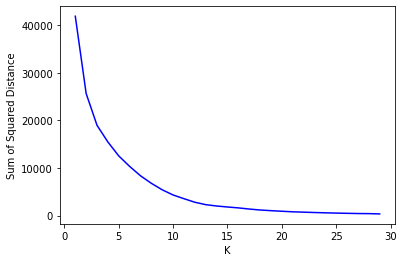

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 5000)
    km.fit(df.iloc[:,:-1])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

### Silhouette Method

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=5000)
    kmeans.fit(df.iloc[:,:-1])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.iloc[:, :-2], df['cluster'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.iloc[:, :-3], df['cluster'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
    #[220811_1518]NOTED k = 10일 때 최적 but 실제는 9

전체 실루엣 계수 평균: 0.477
군집 별 실루엣 계수 평균: 
cluster
0    0.661839
1    0.187387
Name: sil_sam, dtype: float64
score: 0.237
---------------
전체 실루엣 계수 평균: 0.540
군집 별 실루엣 계수 평균: 
cluster
0    0.305079
1    0.637818
2    0.475352
Name: sil_sam, dtype: float64
score: 0.133
---------------
전체 실루엣 계수 평균: 0.542
군집 별 실루엣 계수 평균: 
cluster
0    0.407981
1    0.748121
2    0.470658
3    0.272015
Name: sil_sam, dtype: float64
score: 0.170
---------------
전체 실루엣 계수 평균: 0.585
군집 별 실루엣 계수 평균: 
cluster
0    0.748121
1    0.464428
2    0.554459
3    0.407981
4    0.359396
Name: sil_sam, dtype: float64
score: 0.143
---------------
전체 실루엣 계수 평균: 0.607
군집 별 실루엣 계수 평균: 
cluster
0    0.376816
1    0.748121
2    0.554459
3    0.758083
4    0.407981
5    0.883130
Name: sil_sam, dtype: float64
score: 0.175
---------------
전체 실루엣 계수 평균: 0.639
군집 별 실루엣 계수 평균: 
cluster
0    0.748121
1    0.533254
2    0.407981
3    0.554459
4    0.727420
5    0.740431
6    0.879922
Name: sil_sam, dtype: float64
score: 0.137
--------------

## K-means 모델 생성

In [9]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

### 교차 검증

* 검증 데이터셋 생성x(학습 데이터량의 변화에 따른 모델의 정확도 변화 분석에 용이)

In [10]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 1
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_test = data.iloc[start_index:start_index + len(df.index) // cv]
    y_test = label[start_index:start_index + len(df.index) // cv]
    kmeans = KMeans(n_clusters = len(y_test.unique()), max_iter = 1000)
    kmeans.fit(X_test)
    accuracy.append(np.round(cal_accuracy(y_test, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))
#[220813_1117]NOTED 검증 데이터셋이 없고, 학습 데이터셋의 수는 cv값과 반비례하기 때문에, cv값이 증가함에 따라 정확도는 감소
#[220813_1117]NOTED 학습 데이터 수가 줄어듬에 따라 모델의 정확도 변화율을 분석하기에 용이

교차 검증별 정확도: [0.9171]
평균 검증 정확도: 0.9171


* 검증 데이터셋 생성

In [11]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 5
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_train, X_test = pd.concat([data.iloc[0:start_index], data.iloc[start_index + len(df.index) // cv:]]), data.iloc[start_index:start_index + len(df.index) // cv]
    y_train, y_test = pd.concat([label[0:start_index], label[start_index + len(df.index) // cv:]]), label[start_index:start_index + len(df.index) // cv] 
    #[220813_1108]CREATED X_test, y_test: 검증 데이터셋
    kmeans = KMeans(n_clusters = len(y_train.unique()), max_iter = 1000)
    kmeans.fit(X_train)
    accuracy.append(np.round(cal_accuracy(y_train, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    #[220813_1108]CREATED predict()를 통해 새로운 데이터셋에 대한 cluster 레이블을 출력하여 정답지인 y_test와 비교한다.
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))

교차 검증별 정확도: [0.9828, 0.9056, 0.9021, 0.9115, 0.8972]
평균 검증 정확도: 0.9198


## 차원 축소 및 데이터 분포 확인

In [17]:
km = KMeans(n_clusters = 12, max_iter = 1000)
km.fit(df.iloc[:,:-1])
cal_accuracy(df['target'], km.labels_)

0.917076642222841

In [18]:
df.drop('pca_x', axis = 1, inplace = True)
df.drop('pca_y', axis = 1, inplace = True)
df.drop('cluster', axis = 1, inplace = True)

KeyError: "['pca_x'] not found in axis"

In [88]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,0.545455,5
1,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,0.545455,5
2,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,0.545455,5
3,2,1,5,2,1,4,3,3,3,4,...,2,4,4,3,5,2,3,5,0.939394,4
4,7,1,5,5,1,4,4,1,5,0,...,7,1,7,1,2,2,4,0,0.606061,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,0,2,3,1,1,1,8,1,5,2,...,1,0,5,7,3,0,6,5,0.818182,4
369,1,1,1,3,0,3,5,2,5,1,...,1,1,7,8,1,0,5,3,0.848485,4
370,1,1,2,1,1,3,7,2,4,1,...,1,0,5,9,1,0,5,3,0.848485,4
371,1,1,1,2,0,3,5,2,5,1,...,1,1,7,8,1,0,5,3,0.848485,4


In [100]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca_transformed = pca.fit_transform(df.iloc[:, :-2])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCT,TTA,TTG,TTC,TTT,GC-contents,target,cluster,pca_x,pca_y
0,1,2,3,2,3,4,7,3,6,0,...,6,3,0,5,6,0.545455,5,7,5.707575,0.816405
1,1,2,3,2,3,4,7,3,6,0,...,6,3,0,5,6,0.545455,5,7,5.707575,0.816405
2,1,2,3,2,3,4,7,3,6,0,...,6,3,0,5,6,0.545455,5,7,5.707575,0.816405
3,2,1,5,2,1,4,3,3,3,4,...,3,5,2,3,5,0.939394,4,3,1.473340,-0.440239
4,7,1,5,5,1,4,4,1,5,0,...,1,2,2,4,0,0.606061,8,5,5.324334,2.032612


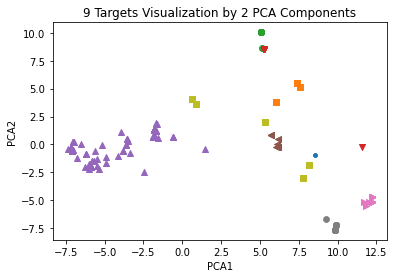

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

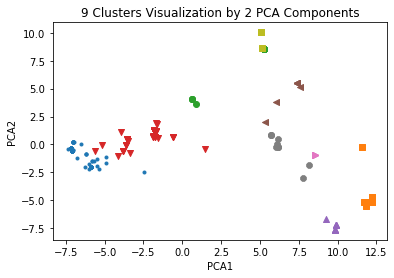

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)
    
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()